In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-expression-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F99505%2F234911%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240430%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240430T221659Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d54a109b371ac71e86167bf1eb7a5ecdf08ec5b199dc611875f2e4bf0961b3581a21919630fe4f35d6c6050a0f010b3f1effc4120623e6828e1b9daf10917e0a5ccd23a595043b30b49e2391d2caeb4bf791618c9069c6db4ac9b18f8e3ed1ea3bc078698c2bf0cc774baefdb05d874e1282ffe9d3ae3ebcc9e27ea604ce70613b82657632f9b85c355465987124b658dacb294d86ce3e7a8306caa946f554adca502e26772b3b16d235475a99d14ec5899234cacf7fa72827eab3f6fa38c605b6245b11e12b26b6b6dc5cc41abb7e4a2fc206d72dae9186eb130b196749a86d59d0bdd0075f084deaa6d04f84259b123107a9dddf1372b53a89c1aa24b9d42'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 126358582 bytes downloaded
Downloaded and uncompressed: face-expression-recognition-dataset
Data source import complete.


In [5]:
# import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [6]:
# setting the directory
picture_size = 48
folder_path = "../input/face-expression-recognition-dataset/images/"


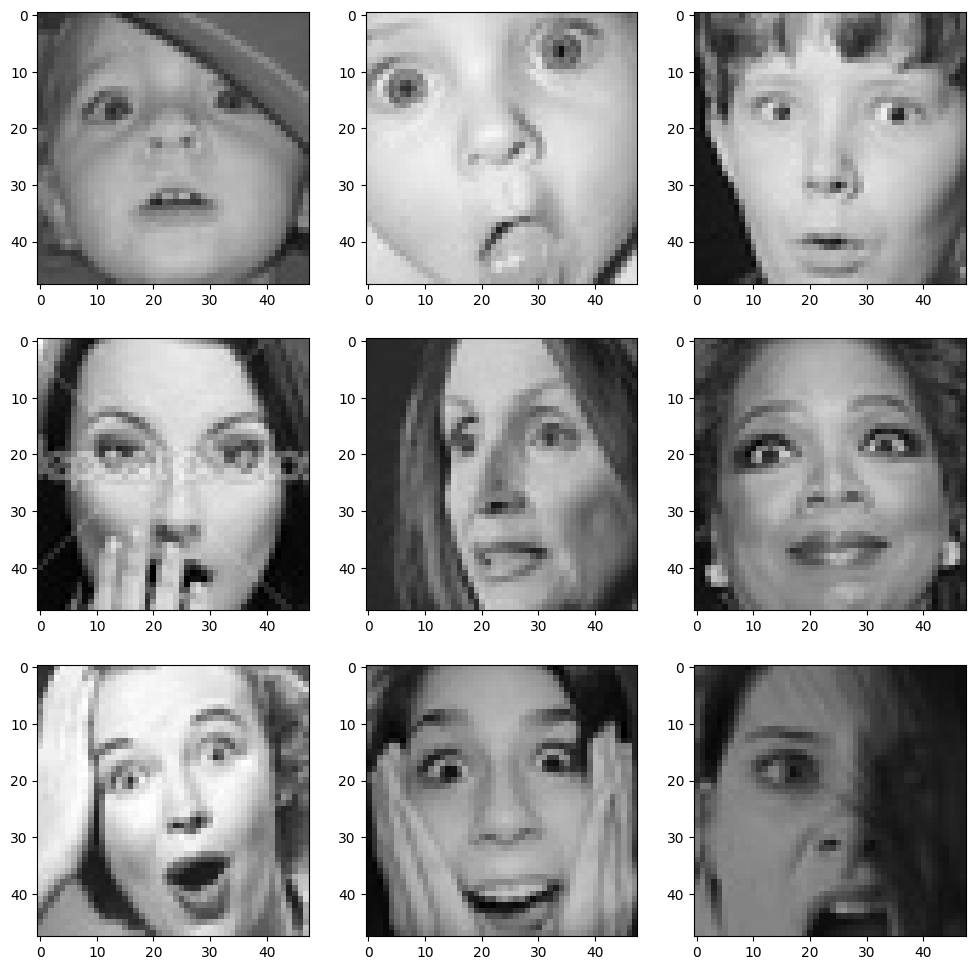

In [7]:
expression = 'surprise'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()


In [16]:
batch_size  = 64

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense, Input

no_of_classes = 7

model = Sequential([
    #1st CNN layer
    Input(shape=(48, 48, 1)),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    #2nd CNN layer
    Conv2D(128, (5, 5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    #3rd CNN layer
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.20),

    #4th CNN layer
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.20),

    Flatten(),

    #Fully connected 1st layer
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # Fully connected layer 2nd layer
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(no_of_classes, activation='softmax')
])

# Set the learning rate in the Adam optimizer
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

In [18]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Monitoring metric
checkpoint = ModelCheckpoint(
    "./model.h5",
    monitor='accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_delta=0.0001
)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 48

# Update the learning rate parameter
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),# here we are setting the learning rate
    metrics=['accuracy']
)


In [19]:
history = model.fit(
    x=train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    callbacks=callbacks_list
)


Epoch 1/48
449/450 [============================>.] - ETA: 0s - loss: 1.7111 - accuracy: 0.3430
Epoch 1: accuracy improved from -inf to 0.34319, saving model to ./model.h5
450/450 [==============================] - 25s 43ms/step - loss: 1.7110 - accuracy: 0.3432 - val_loss: 1.6568 - val_accuracy: 0.4091 - lr: 0.0010
Epoch 2/48
450/450 [==============================] - ETA: 0s - loss: 1.3561 - accuracy: 0.4841
Epoch 2: accuracy improved from 0.34319 to 0.48413, saving model to ./model.h5
450/450 [==============================] - 19s 42ms/step - loss: 1.3561 - accuracy: 0.4841 - val_loss: 1.3996 - val_accuracy: 0.4536 - lr: 0.0010
Epoch 3/48
450/450 [==============================] - ETA: 0s - loss: 1.2254 - accuracy: 0.5324
Epoch 3: accuracy improved from 0.48413 to 0.53236, saving model to ./model.h5
450/450 [==============================] - 19s 43ms/step - loss: 1.2254 - accuracy: 0.5324 - val_loss: 1.4441 - val_accuracy: 0.4443 - lr: 0.0010
Epoch 4/48
450/450 [====================